The purpose of this file is to calculate RSCU values for codons in a given sequence, optionally using a sliding window approach and considering cleavage sites. It includes functionality to visualize the RSCU values and filter them based on variance thresholds.

In [ ]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))

from Bio import SeqIO
from lib.calculations import run_rscu_analysis
import pandas as pd
import numpy as np
from lib.aminoacids import AA_TO_CODONS_MULTI_CODON_FAMILIES, SLOW, FAST

In [2]:
############ Variables ###########

# Note that the distance variable (d_aa) can be set for each sequence individually when external data is available
# Here we set a default value for all sequences
# The cell below builds an array from this default value, but this can be replaced with an array built from external data

w_aa = 21  # window size in amino acids
d_aa = 35  # distance from cleavage site in amino acids
UseCs = True # when true, we measure the window as the distance from the cleavage site, otherwise from start codon
UseSpAsWindow = False # when true, the window we extract is only the SP region, not a fixed window size

In [4]:
########## For loading DeepTMHMM data #####################

# adjust for nucleotides
w_n = int(w_aa*3) # window size in nucleotides
d_n = int(d_aa*3) # distance from cleavage site in nucleotides

# load SP ORFS (genomic)
all_fasta_path = '../data/dep_dna_filtered.fasta'
records = list(SeqIO.parse(all_fasta_path, 'fasta'))

# load hydrophobic region data
tsv_path = '../data/dependent_hydrophobic_genes.csv'
df = pd.read_csv(tsv_path, index_col='gene')

# build numpy array of hydrophobic region end values corresponding to the ordering of records
arr_cs_aa = np.zeros(len(records))
for i, record in enumerate(records):
    row = df.loc[record.id]
    arr_cs_aa[i] = row['first_hydrophobic_end'] if UseCs else 0
arr_cs_n = arr_cs_aa * 3

# build numpy array of npet values, can be loaded with external data when available
arr_npet_n = np.full(len(records), d_n, dtype=int) # set using distance variable above for now

max_len = max(len(record.seq) for record in records)
min_len = min(len(record.seq) for record in records)
print(f"Min length of records: {min_len}")
print(f"Max length of records: {max_len}")

max_cs = df['first_hydrophobic_end'].max()
min_cs = df['first_hydrophobic_end'].min()
print(f"Max hydrophobic_end: {max_cs}")
print(f"Min hydrophobic_end: {min_cs}")

window_rscu, full_rscu = run_rscu_analysis(records, arr_cs_n, arr_npet_n, w_n, UseCs, UseSpAsWindow)

Min length of records: 228
Max length of records: 8877
Max hydrophobic_end: 83.0
Min hydrophobic_end: 10.0
Invalid sequence: length is not a multiple of three
Invalid ORF for record YBL040C: complement valid: False, window valid: True
Invalid sequence: length is not a multiple of three
Invalid ORF for record YCL002C: complement valid: False, window valid: True
Invalid sequence: length is not a multiple of three
Invalid ORF for record YDR367W: complement valid: False, window valid: True
Invalid sequence: length is not a multiple of three
Invalid ORF for record YHR123W: complement valid: False, window valid: True
Invalid sequence: length is not a multiple of three
Invalid ORF for record YJR112W-A: complement valid: False, window valid: True
Invalid sequence: length is not a multiple of three
Invalid ORF for record YMR292W: complement valid: False, window valid: True
Invalid sequence: length is not a multiple of three
Invalid ORF for record YNL130C: complement valid: False, window valid: 

In [5]:
########### Save RSCU values #########

from lib.data_access_helpers import save_rscu

save_rscu(f"../data/rscu/dep_genes_w{w_aa}_d{d_aa}.tsv", window_rscu, full_rscu)

Saved RSCU data to ../data/rscu/dep_genes_w21_d35.tsv


In [6]:
# RSCU values to numpy arrays

rscu_w = np.array(list(window_rscu.values()))
rscu_b = np.array(list(full_rscu.values()))

codons = list(window_rscu.keys())

diffs = rscu_w - rscu_b
avg_diffs = np.mean(diffs)

ratios = rscu_w / rscu_b
avg_ratios = np.mean(ratios)

print("Sanity check...")
print(f"    Average difference: {avg_diffs:.3f}")
print(f"    Average ratio: {avg_ratios:.3f}")

print("Differences between window and complement ORF RSCU values (window - background):")
for codon, diff in zip(codons, diffs): 
    print(f"{codon}: {diff:.3f}")

Sanity check...
    Average difference: 0.000
    Average ratio: 1.023
Differences between window and complement ORF RSCU values (window - background):
GCT: -0.158
GCC: 0.079
GCA: 0.045
GCG: 0.034
CGT: 0.035
CGC: 0.024
CGA: 0.073
CGG: 0.065
AGA: -0.165
AGG: -0.032
AAT: -0.113
AAC: 0.113
GAT: -0.135
GAC: 0.135
TGT: 0.128
TGC: -0.128
CAA: -0.058
CAG: 0.058
GAA: -0.030
GAG: 0.030
GGT: -0.080
GGC: 0.082
GGA: -0.122
GGG: 0.121
CAT: -0.053
CAC: 0.053
ATT: -0.052
ATC: -0.010
ATA: 0.061
TTA: -0.079
TTG: -0.152
CTT: 0.046
CTC: -0.054
CTA: 0.099
CTG: 0.140
AAA: -0.004
AAG: 0.004
TTT: 0.053
TTC: -0.053
CCT: 0.191
CCC: 0.012
CCA: -0.347
CCG: 0.144
TCT: 0.170
TCC: 0.011
TCA: -0.282
TCG: 0.065
AGT: 0.006
AGC: 0.029
ACT: -0.035
ACC: 0.042
ACA: 0.036
ACG: -0.043
TAT: 0.021
TAC: -0.021
GTT: -0.232
GTC: 0.033
GTA: 0.064
GTG: 0.134


In [7]:
############# Analyze by codon family #############

VARIANCE_THRESHOLD = 0.01

aa_codon_dict = {
    aa: {codon: 0 for codon in codons_lst}
    for aa, codons_lst in AA_TO_CODONS_MULTI_CODON_FAMILIES.items()
}

for i in range(len(codons)):
    codon = codons[i]
    diff = diffs[i]
    for aa, codons_lst in AA_TO_CODONS_MULTI_CODON_FAMILIES.items():
        if codon in codons_lst:
            aa_codon_dict[aa][codon] = diff
     
variances = {aa: np.var(list(codon_family.values())) for aa, codon_family in aa_codon_dict.items()}
print("Variance of differences by amino acid:")
for aa, var in variances.items():
    print(f"{aa}: {var:.3f}")
                
print("Differences by amino acid:")
for aa, codon_family in aa_codon_dict.items():
    print(f"{aa}:")
    for codon, diff in codon_family.items():
        print(f"  {codon}: {diff:.3f}")
    var = np.var(list(codon_family.values()))
    print(f"  Sum: {sum(codon_family.values()):.3f}")
    print(f"  Variance: {var:.3f}")
    
    
##### filter codon list for the scatterplot by family variance threshold
varied_aa = [aa for aa, var in variances.items() if var >= VARIANCE_THRESHOLD]
print(f"Amino acids with variance >= {VARIANCE_THRESHOLD}: {varied_aa}")

filtered_w = []
filtered_b = []
filtered_codons = []
for aa in varied_aa:
    for codon, diff in aa_codon_dict[aa].items():
        i = codons.index(codon)
        filtered_w.append(rscu_w[i])
        filtered_b.append(rscu_b[i])
        filtered_codons.append(codon)
        
filtered_b = np.array(filtered_b)
filtered_w = np.array(filtered_w)



Variance of differences by amino acid:
A: 0.009
R: 0.007
N: 0.013
D: 0.018
C: 0.016
Q: 0.003
E: 0.001
G: 0.011
H: 0.003
I: 0.002
L: 0.011
K: 0.000
F: 0.003
P: 0.044
S: 0.019
T: 0.002
Y: 0.000
V: 0.019
Differences by amino acid:
A:
  GCT: -0.158
  GCC: 0.079
  GCA: 0.045
  GCG: 0.034
  Sum: 0.000
  Variance: 0.009
R:
  CGT: 0.035
  CGC: 0.024
  CGA: 0.073
  CGG: 0.065
  AGA: -0.165
  AGG: -0.032
  Sum: 0.000
  Variance: 0.007
N:
  AAT: -0.113
  AAC: 0.113
  Sum: -0.000
  Variance: 0.013
D:
  GAT: -0.135
  GAC: 0.135
  Sum: -0.000
  Variance: 0.018
C:
  TGT: 0.128
  TGC: -0.128
  Sum: 0.000
  Variance: 0.016
Q:
  CAA: -0.058
  CAG: 0.058
  Sum: -0.000
  Variance: 0.003
E:
  GAA: -0.030
  GAG: 0.030
  Sum: 0.000
  Variance: 0.001
G:
  GGT: -0.080
  GGC: 0.082
  GGA: -0.122
  GGG: 0.121
  Sum: 0.000
  Variance: 0.011
H:
  CAT: -0.053
  CAC: 0.053
  Sum: -0.000
  Variance: 0.003
I:
  ATT: -0.052
  ATC: -0.010
  ATA: 0.061
  Sum: -0.000
  Variance: 0.002
L:
  TTA: -0.079
  TTG: -0.152
  CTT:

In [8]:

colours = ['k'] * len(codons)

for codon in SLOW:
    index = codons.index(codon)
    colours[index] = 'r' # slow codon
    
for codon in FAST:
    index = codons.index(codon)
    colours[index] = 'b'  # fast codon
    


filtered_colours = ['k'] * len(filtered_codons)

for codon in SLOW:
    if codon not in filtered_codons:
        continue
    index = filtered_codons.index(codon)
    filtered_colours[index] = 'r' # slow codon
    
for codon in FAST:
    if codon not in filtered_codons:
        continue
    index = filtered_codons.index(codon)
    filtered_colours[index] = 'b'  # fast codon

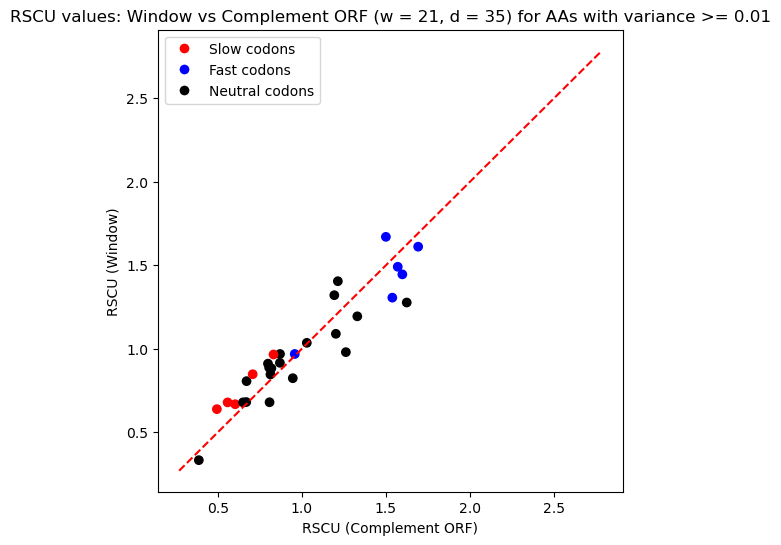

In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


plt.figure(figsize=(6, 6))
plt.scatter(filtered_b, filtered_w, c = filtered_colours)
plt.xlabel('RSCU (Complement ORF)')
plt.ylabel('RSCU (Window)')
if UseSpAsWindow is False:
    plt.title(f'RSCU values: Window vs Complement ORF (w = {w_aa}, d = {d_aa}) for AAs with variance >= {VARIANCE_THRESHOLD}')
else:   
    plt.title(f'RSCU values: SP vs Complement ORF for AAs with variance >= {VARIANCE_THRESHOLD}')
plt.plot([min(rscu_b), max(rscu_b)], [min(rscu_b), max(rscu_b)], 'r--')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Slow codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Fast codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Neutral codons')]

plt.legend(handles=legend_elements, loc='upper left')
plt.show()

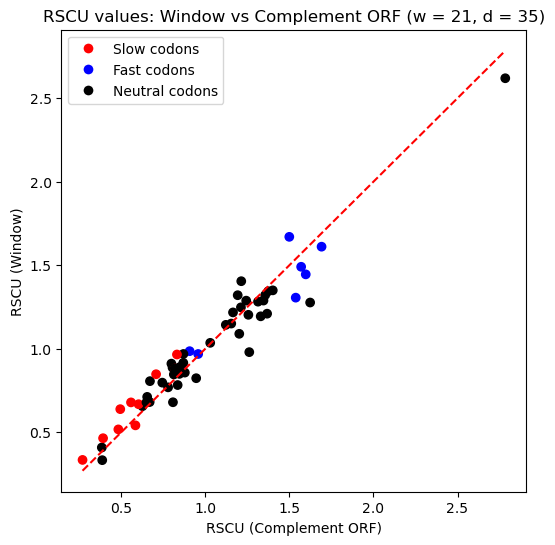

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


plt.figure(figsize=(6, 6))
plt.scatter(rscu_b, rscu_w, c = colours)
plt.xlabel('RSCU (Complement ORF)')
plt.ylabel('RSCU (Window)')
if UseSpAsWindow is False:
    plt.title(f'RSCU values: Window vs Complement ORF (w = {w_aa}, d = {d_aa})')
else:   
    plt.title(f'RSCU values: SP vs Complement ORF')
plt.plot([min(rscu_b), max(rscu_b)], [min(rscu_b), max(rscu_b)], 'r--')
# Create custom legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Slow codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Fast codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Neutral codons')]

plt.legend(handles=legend_elements, loc='upper left')
plt.show()